In [1]:
# === project setup ===
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
print("PROJECT_ROOT =", PROJECT_ROOT)

if not (PROJECT_ROOT / "src").exists():
    raise RuntimeError("src directory not found — wrong PROJECT_ROOT")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROJECT_ROOT = C:\Users\ХБ\Documents\projects\analysis_tools


In [2]:
# === imports ===
from h5py import File 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import copy
import importlib
import pandas as pd
import h5py

In [244]:
from scipy.signal import ShortTimeFFT


In [3]:
from src.utils.parse_h5df import * 
from src.utils.events import * 
from src.utils.spectral_analysis import *
from src.utils.transformations import unit_to_db
from src.utils.montage_processing import *
from src.utils.rereferencing import *

In [139]:
from scipy.io import loadmat

In [27]:
DATA_FOLDER = r"D:\data\BCI Competition IV"
records = os.listdir(DATA_FOLDER)
records = [record for record in os.listdir(DATA_FOLDER) if record.find("calib") != -1]

In [ ]:
data = loadmat(os.path.join(DATA_FOLDER, records[0]))
x = data["nfo"]["xpos"][0][0]
y = data["nfo"]["ypos"][0][0]
xy = np.concatenate([y, x], axis=1)
ch_labels = data["nfo"]["clab"][0][0][0]
ch_labels = np.concatenate(ch_labels)

In [ ]:
def load_data(filename):
    data = loadmat(filename)
    eeg =  0.1* data["cnt"].astype(np.float64)
    trigger = data["mrk"]["pos"][0][0][0]
    labels = data["mrk"]["y"][0][0][0]
    return eeg, trigger, labels

dataset = []
for record in records:
    eeg, trigger, labels = load_data(os.path.join(DATA_FOLDER, record))

    break

[100]


In [81]:
eeg.shape, trigger.shape, labels.shape

((190594, 59), (200,), (200,))

In [94]:
mask_left = (labels == -1)
mask_right = (labels == 1)

In [113]:
from scipy.signal import butter, sosfiltfilt

def filter(eeg, N=4, lo=8, hi=15, fs=100):
    # частотный фильтр
    sos = butter(N=N, Wn=(lo, hi), btype='bandpass', output='sos', fs=fs)
    return sosfiltfilt(np.ascontiguousarray(sos), eeg, axis=0)

eeg_f = filter(eeg)

In [117]:
def get_epochs(data, idxs, epoch_dur=4000, Fs=100):
    dur = epoch_dur // (1000 // Fs)
    epochs = [data[idx:idx+dur, :] for idx in idxs] # if idx+epoch_dur < data.shape[0]]
    return np.array(epochs)

epochs = get_epochs(eeg_f, trigger)
epochs.shape

(200, 400, 59)

In [140]:
from src.utils.CSP import calculate_CSP, calculate_robust_cov
cov1 = calculate_robust_cov(epochs[mask_left, 25:-25, :]).covariance_
cov2 = calculate_robust_cov(epochs[mask_right, 25:-25, :]).covariance_

In [141]:
projInverse, projForward, evals = calculate_CSP(cov1, cov2)

In [ ]:
from mne.viz import plot_topomap
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap

viridisBig = cm.get_cmap('jet')
newcmp = ListedColormap(viridisBig(np.linspace(0, 1, 15)))

In [224]:
from src.visualization.plot_csp_components import plot_CSP_components
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [210]:
def plot_eigenvalues(eigvals, ax):
        ax.plot(eigvals, "k")
        ax.scatter(range(len(eigvals)), eigvals, marker="o", s=20)
        ax.set_ylim(0, 1)
        ax.set_title("Eigenvalues")

        ediff = np.diff(eigvals)
        ok_steps = np.where(ediff > np.median(ediff) * 5)[0]
        ok_evalLow_inds = np.arange(np.max(ok_steps[ok_steps < 10]))
        ok_evalHigh_inds = np.arange(len(eigvals)-1, np.min(ok_steps[ok_steps > 30]), -1)
        
        ax.scatter(ok_evalLow_inds, eigvals[ok_evalLow_inds],  label='ERD OK')
        ax.scatter(ok_evalHigh_inds, eigvals[ok_evalHigh_inds], label='ERS OK')

def plot_topoplot(X, positions, vmin=None, vmax=None, axes=None):
        im, cn = plot_topomap(X, positions,  
                size=5, show=False, contours=0, sphere=0.6, 
                cmap=newcmp, extrapolate='head', axes=axes, vlim=[vmin, vmax])
        return im

In [220]:
xy_rot = xy.copy()
xy_rot[:, 0] = -xy[:, 1]
xy_rot[:, 1] = xy[:, 0]

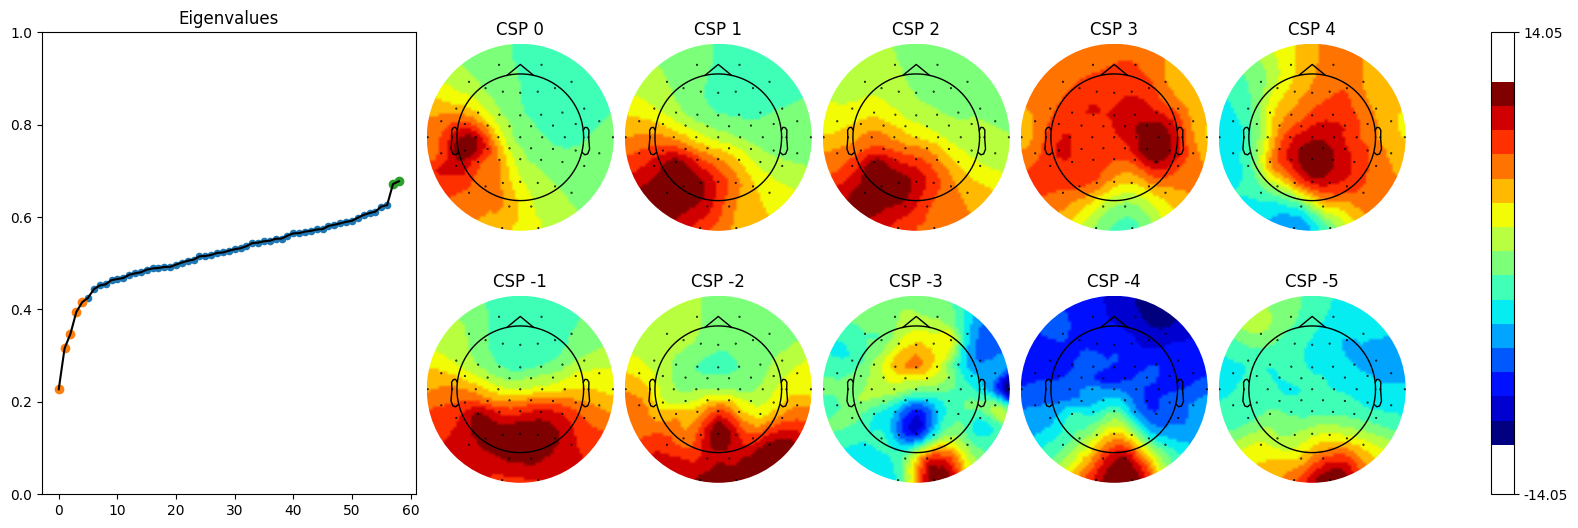

In [ ]:
fig = plt.figure(figsize=(22, 6))
n = 6
gs = gridspec.GridSpec(2, n, height_ratios=[1, 1], width_ratios=[2]+[1]*(n-1), wspace=0.05)

plot_eigenvalues(abs(evals), plt.subplot(gs[:, 0]))

idxs = [0, 1, 2, 3, 4, -5, -4, -3, -2, -1]
vmin, vmax = np.min(projForward[:, idxs]), np.max(projForward[:, idxs])
vmin, vmax = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
for i, ch in enumerate(idxs):
    ax = plt.subplot(gs[int(ch<0), abs(ch)+1*int(ch>=0)])
    im, _ = plot_topomap(projForward[:, ch], xy_rot, size=5, axes=ax, show=False, contours=0, sphere=0.6, cmap=newcmp, extrapolate='head') #, names=ch_labels)
    ax.set_title(f'CSP {ch}')

cbar = fig.colorbar(im, ax=fig.axes)
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])
cbar.ax.yaxis.set_tick_params(labelsize=10)

In [249]:
sel_channels = [0, 1, 2, 3]
eeg_csp = eeg @ projInverse[:, sel_channels]
eeg_csp_epochs = get_epochs(eeg_csp, trigger)
eeg_csp_epochs.shape

(200, 400, 4)

In [273]:
eeg_left = np.concatenate(eeg_csp_epochs[mask_left, :, :], axis=0)
eeg_right = np.concatenate(eeg_csp_epochs[mask_right, :, :], axis=0)
eeg_left.shape, eeg_right.shape

((40000, 4), (40000, 4))

In [278]:
def get_fft(eeg, Fs=100, hop=10, window=100):
    SFT = ShortTimeFFT(win=np.ones(window), hop=hop, fs=Fs,  fft_mode='onesided' )
    fft_res = np.abs(SFT.stft(eeg, axis=0)) ** 2
    fft_t = SFT.t(len(eeg))
    return fft_res, fft_t

fft_res_1, fft_t_1 = get_fft(eeg_left)
fft_res_2, fft_t_2 = get_fft(eeg_right)
fft_res_1.shape, fft_t_1.shape

((51, 4, 4009), (4009,))

In [288]:
fft_mean_1 = np.mean(10 * np.log(fft_res_1), axis=2)
fft_mean_2 = np.mean(10 * np.log(fft_res_2), axis=2)
fft_mean_1.shape

(51, 4)

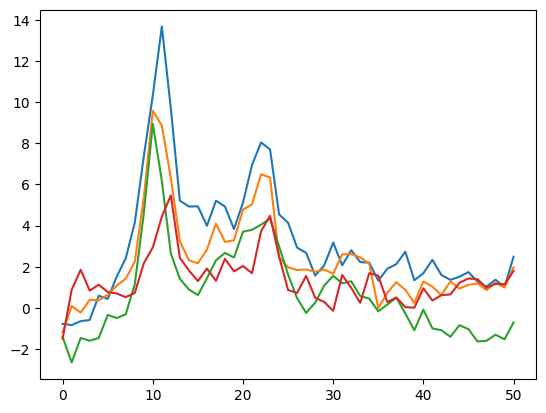

In [292]:
ch = [0, 1, 2, 3]
plt.plot(fft_mean_2[:, ch]-fft_mean_1[:, ch])

In [ ]:
diff_ind_f = [10, 11, 12, 21, 22, 23]

feature_1 = np.mean(fft_res_1[diff_ind_f, :, :], axis=0)
feature_2 = np.mean(fft_res_2[diff_ind_f, :, :], axis=0)